# Exploratory Data Analysis

Exploratory data analysis of Bixi 2021 open data. 

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
from shapely.geometry import box, Point
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster
import scipy.stats as ss

/Users/besombes/env/ds_py39/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
data_folder = 'data/Historique-BIXI-2021/'
stations_file = '2021_stations.csv'
data_file = '2021_donnees_ouvertes.csv'

Two CSV files are available : 
  - 2021_stations.csv contains the name and position data each stations
  - 2021_donnees_ouvertes.csv contains the 5M bike travels.

2021_stations.csv enumerates all the parking stations with their name and position (latitude, longitude). 

In [3]:
df_stations = pd.read_csv(data_folder+stations_file)
df_stations.head()

pk                                         name   latitude  longitude
0  10  Métro Angrignon (Lamont /  des Trinitaires)  45.446910 -73.603630
1  13       Métro de l'Église (Ross / de l'Église)  45.462726 -73.565959
2  17                            Tolhurst / Fleury  45.544149 -73.667520
3  21                     St-Christophe / Cherrier  45.520290 -73.568119
4  31                        Lespérance / de Rouen  45.538839 -73.552779

2021_donnees_ouverte.csv shows approximately 5.5 million bike displacements. It gives for each displacement the index of the starting and ending parking station, the duration of the displacement in seconds and if the displacement was done by someone with a member status or not.

In [4]:
df_data = pd.read_csv(data_folder+data_file)
df_data

start_date  emplacement_pk_start  \
0        2021-06-29 17:46:28.653                    10   
1        2021-04-25 18:02:39.110                    10   
2        2021-08-08 18:50:31.633                    10   
3        2021-10-11 17:50:15.346                    10   
4        2021-09-10 15:51:58.050                    10   
...                          ...                   ...   
5566346  2021-11-10 18:17:49.654                  1140   
5566347  2021-11-11 14:55:04.039                  1140   
5566348  2021-11-12 14:50:15.504                  1140   
5566349  2021-11-13 07:00:16.679                  1140   
5566350  2021-11-12 06:52:55.865                  1140   

                        end_date  emplacement_pk_end  duration_sec  is_member  
0        2021-06-29 19:33:25.700                  10          6417          0  
1        2021-04-25 18:13:26.139                 188           647          0  
2        2021-08-08 18:58:57.585                 778           505          1  
3        2021-10-11 18:25:31.726                 504          2116          1  
4        2021-09-10 16:21:01.403                 780          1743          1  
...                          ...                 ...           ...        ...  
5566346  2021-11-10 18:24:40.643                 928           410          1  
5566347  2021-11-11 14:59:41.446                1140           277          0  
5566348  2021-11-12 15:05:37.379                1140           921          1  
5566349  2021-11-13 07:15:10.760                 945           894          1  
5566350  2021-11-12 07:10:43.917                 945          1068          1  

[5566351 rows x 6 columns]

The first step is to verify the presence of null values :

In [5]:
df_data.isnull().any()

start_date              False
emplacement_pk_start    False
end_date                False
emplacement_pk_end      False
duration_sec            False
is_member               False
dtype: bool

In [6]:
df_stations.isnull().any()

pk           False
name         False
latitude     False
longitude    False
dtype: bool

No null values were detected. It is now time to start dive into the data !

<Axes: xlabel='is_member', ylabel='Count'>

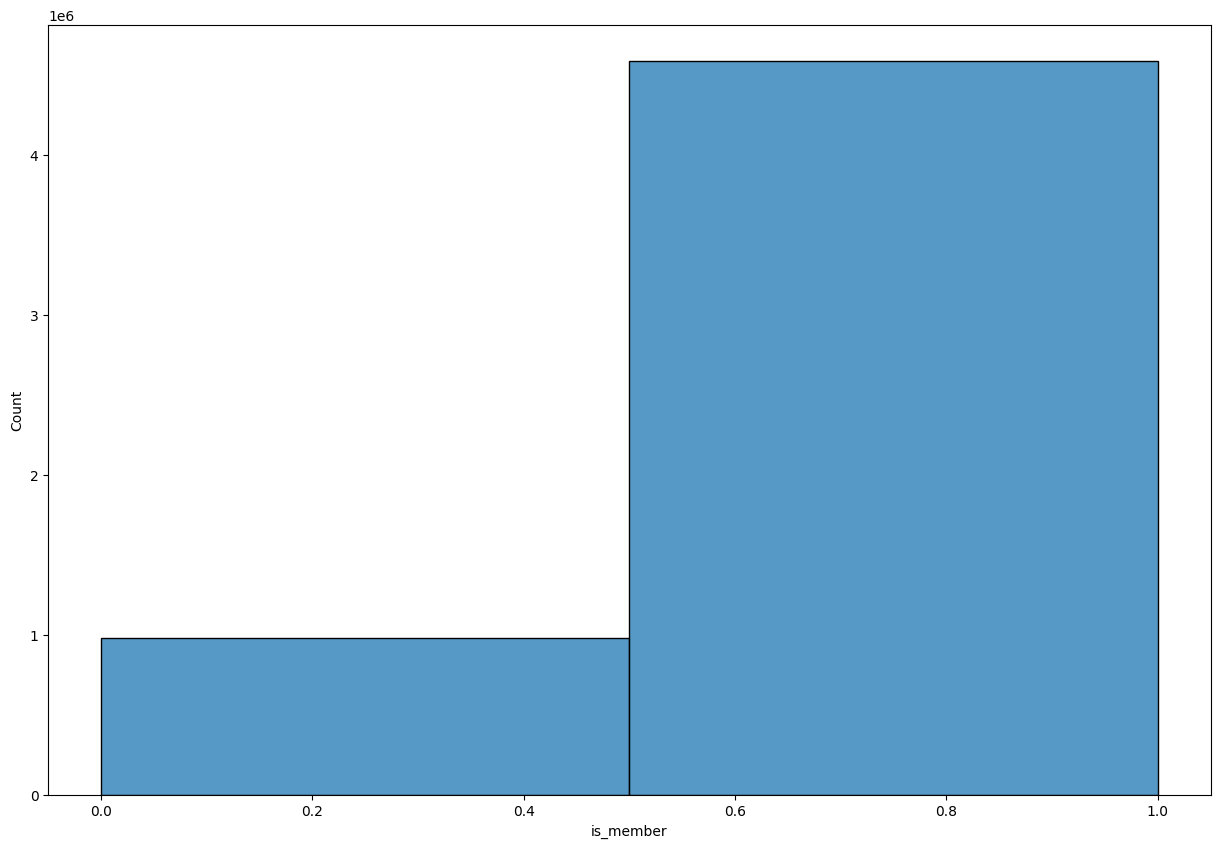

In [7]:
plt.figure(figsize=(15,10))
sns.histplot(data=df_data, x='is_member', bins=2)

There are 4 times more members than non-members. If the dataset represents the totality of the displacement for 2021 the bixi service is well adopted by Montreal inhabitants.

## Displacement duration

First as an exploratory data analysis, it is interesting to see the share of displacement done by members and not members in function of the duration of the displacement. 

<Axes: xlabel='duration_sec', ylabel='Count'>

/Users/besombes/env/ds_py39/lib/python3.9/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/besombes/env/ds_py39/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


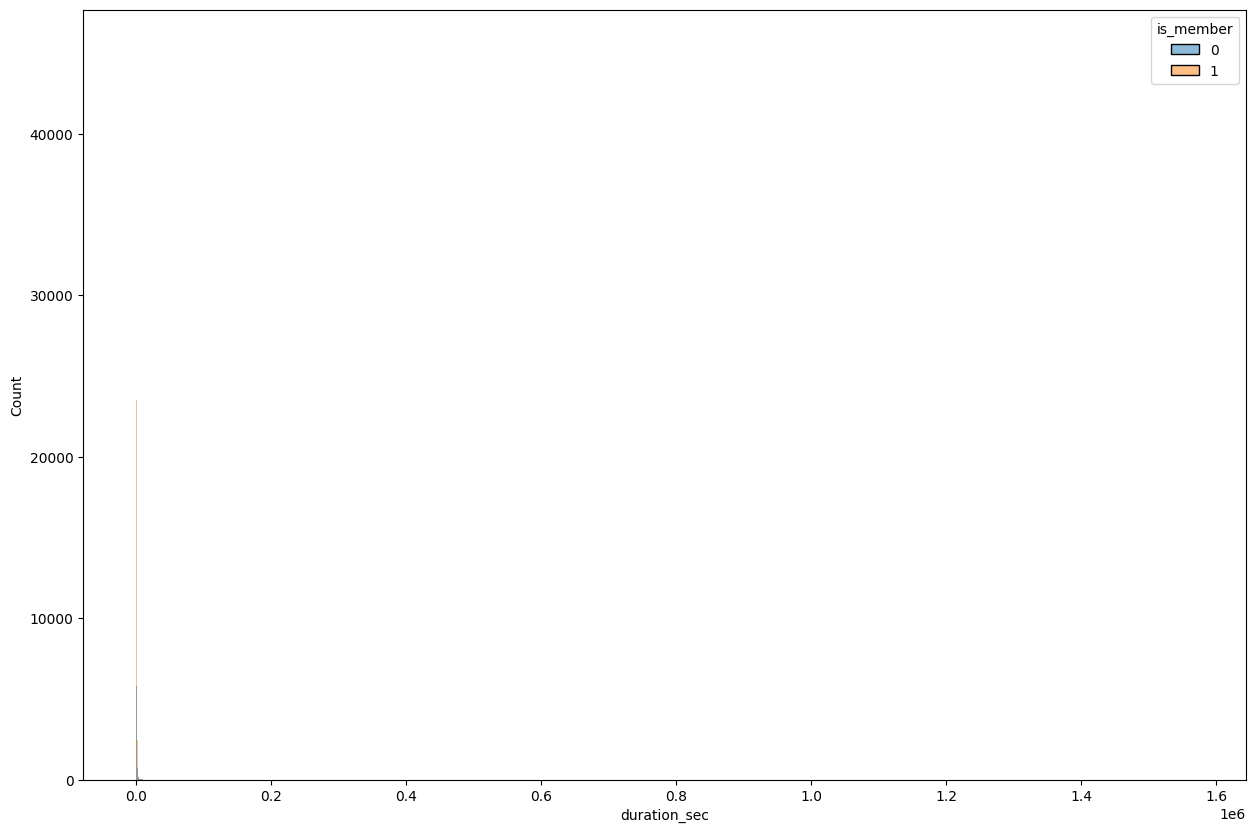

In [8]:
plt.figure(figsize=(15,10))
sns.histplot(data=df_data, x='duration_sec', hue='is_member')

/Users/besombes/env/ds_py39/lib/python3.9/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


<Axes: xlabel='duration_sec', ylabel='Count'>

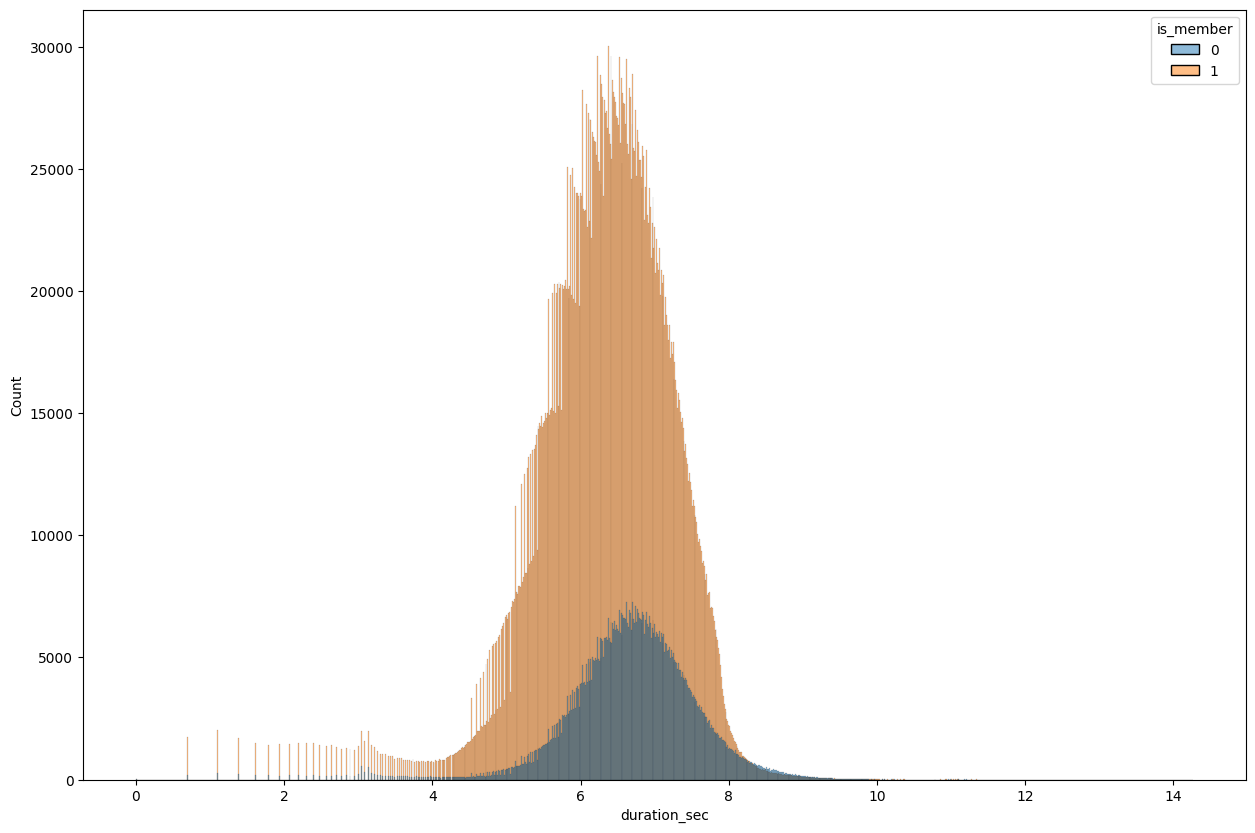

In [9]:
plt.figure(figsize=(15,10))
sns.histplot(x=np.log(df_data['duration_sec']), hue=df_data['is_member'])

Plotting the histogram of the logarithm of the duration gives distributions close to a Gaussian distribution. It means that the duration could be fitted by a lognorm distribution. It is not tackled in this notebook but it is an interesting conclusion of the exploratory data analysis. 

The histogram x-axis is going until 14000 sec (which is equivalent to 4 hours) which seems a very long travel. Let's see how many of these very long trips are present in the data. 

In [10]:
max_duration = df_data['duration_sec'].max()
print(f'The maximum duration is equal to {max_duration} seconds')

The maximum duration is equal to 1565260 seconds


In [11]:
very_long_trip = df_data[df_data['duration_sec']>4000]
print(f'Number of displacements longer than 4000 seconds : {very_long_trip["duration_sec"].count()}')

Number of displacements longer than 4000 seconds : 46149


## Parking usage

The distribution of the starting point and finishing point are now explored. 

<Axes: xlabel='emplacement_pk_start', ylabel='Count'>

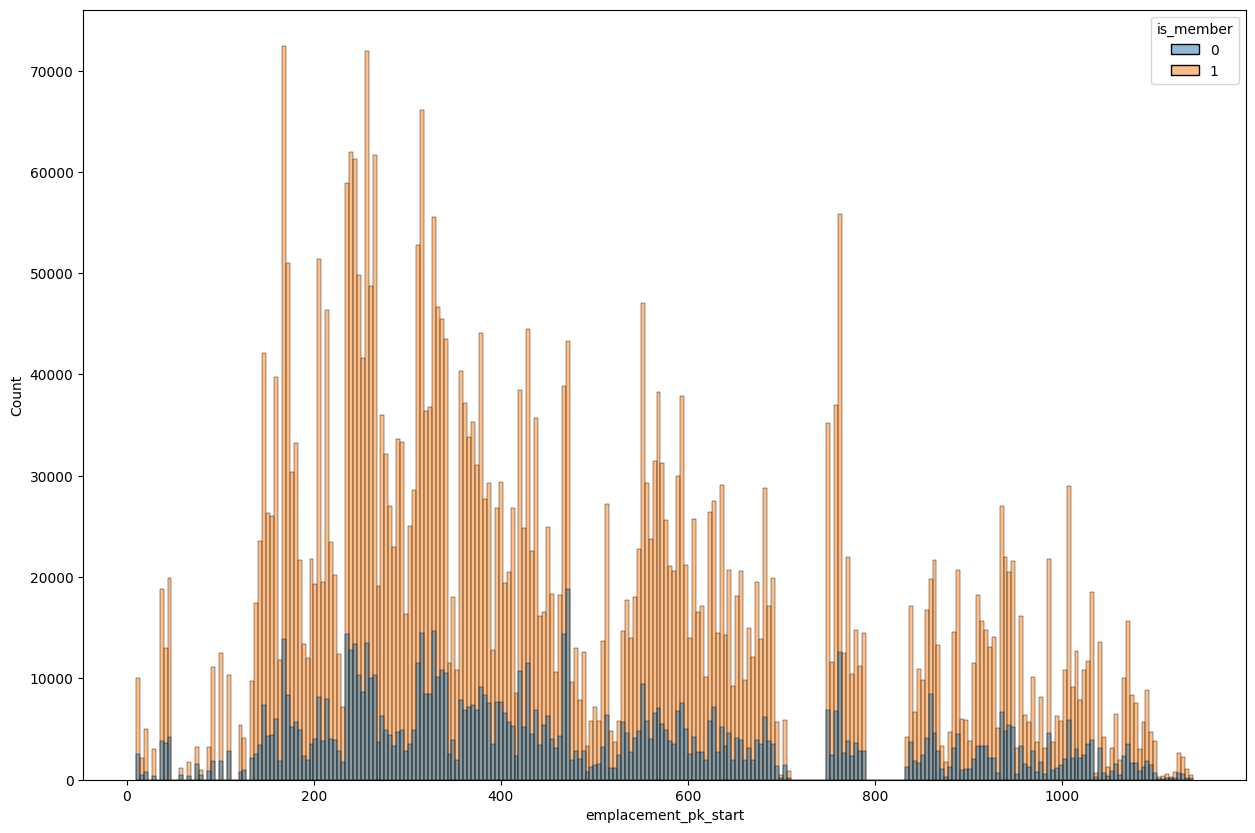

In [12]:
plt.figure(figsize=(15,10))
sns.histplot(data=df_data, x='emplacement_pk_start', hue='is_member')

<Axes: xlabel='emplacement_pk_end', ylabel='Count'>

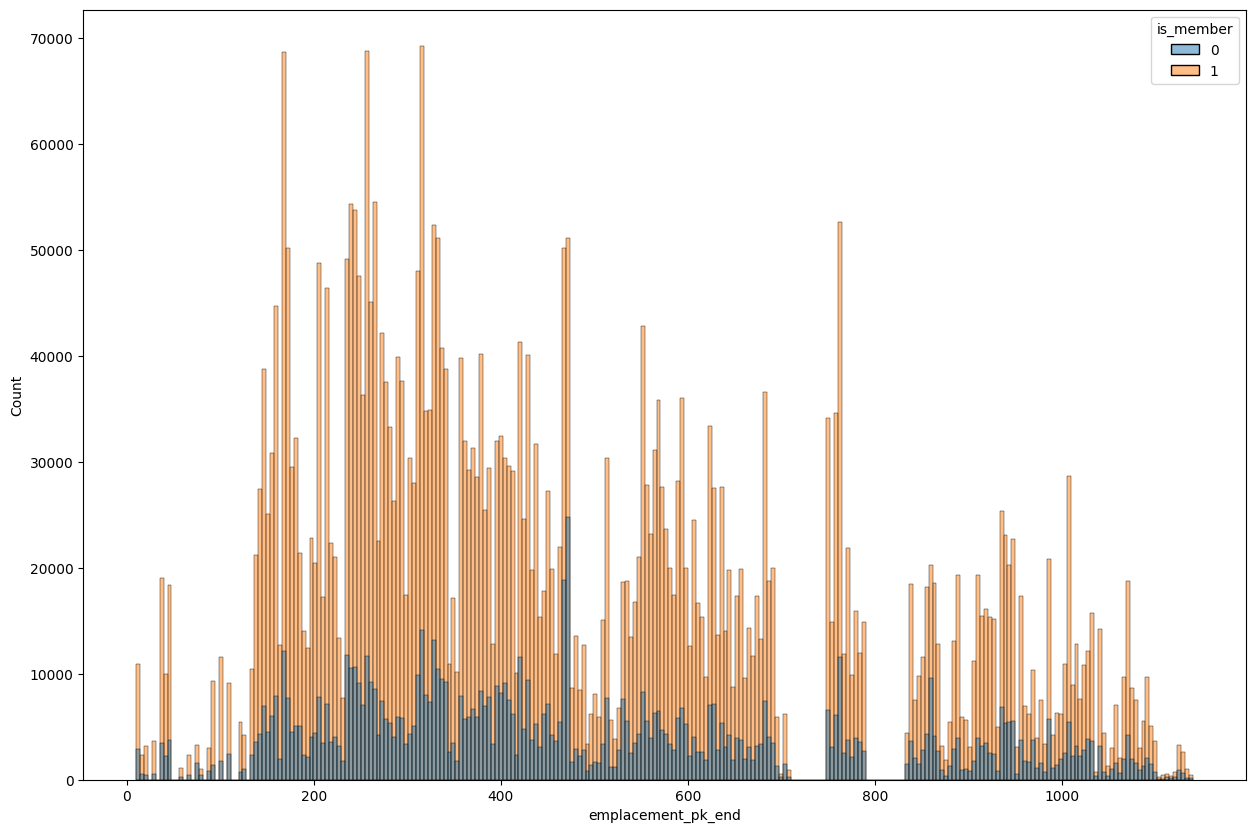

In [13]:
plt.figure(figsize=(15,10))
sns.histplot(data=df_data, x='emplacement_pk_end', hue='is_member')

These plots do not give interesting information. 

It should be used with the other .csv files that gives the localization of the parking stations that gives their geolocalizations.

In [14]:
import geopandas as gpd



world = gpd.read_file('https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip')

cities = gpd.read_file('https://naciscdn.org/naturalearth/110m/cultural/ne_110m_populated_places_simple.zip')
# world = gpd.read_file(gpd.datasets.get_path('https://www.naturalearthdata.com/downloads/110m-cultural-vectors/naturalearth_lowres'))

In [15]:
gdf = gpd.GeoDataFrame(df_stations, geometry=gpd.points_from_xy(df_stations.longitude, df_stations.latitude))

In [16]:
print(world)
world.CONTINENT

          featurecla  scalerank  LABELRANK                   SOVEREIGNT  \
0    Admin-0 country          1          6                         Fiji   
1    Admin-0 country          1          3  United Republic of Tanzania   
2    Admin-0 country          1          7               Western Sahara   
3    Admin-0 country          1          2                       Canada   
4    Admin-0 country          1          2     United States of America   
..               ...        ...        ...                          ...   
172  Admin-0 country          1          5           Republic of Serbia   
173  Admin-0 country          1          6                   Montenegro   
174  Admin-0 country          1          6                       Kosovo   
175  Admin-0 country          1          5          Trinidad and Tobago   
176  Admin-0 country          1          3                  South Sudan   

    SOV_A3  ADM0_DIF  LEVEL               TYPE TLC  \
0      FJI         0      2  Sovereign countr

0            Oceania
1             Africa
2             Africa
3      North America
4      North America
           ...      
172           Europe
173           Europe
174           Europe
175    North America
176           Africa
Name: CONTINENT, Length: 177, dtype: object

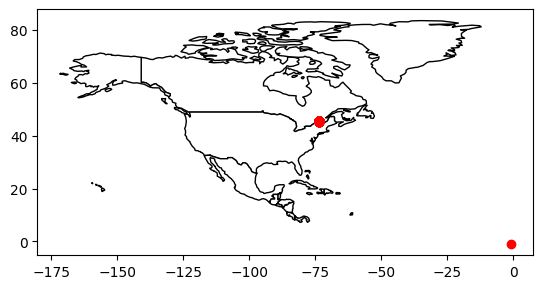

In [17]:
ax = world[world.CONTINENT == 'North America'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

We should note that one point is not located in Montreal, it is an error in the database. It can be easily corrected, by finding which stations does not have correct latitude and longitude.

In [18]:
df_stations[df_stations['longitude']>=-5]

pk          name  latitude  longitude
570  856  Smith / Peel      -1.0       -1.0

The parking station at the angle of Smith st and Peel St. Using google maps it is possible to find its correct longitude and latitude. 

In [19]:
lat, long = 45.49277056666423, -73.5564096881966
df_stations['latitude'] = df_stations['latitude'].replace(to_replace=-1.0, value=lat)
df_stations['longitude'] = df_stations['longitude'].replace(to_replace=-1.0, value=long)
print(df_stations[df_stations['longitude']>=-5])

Empty DataFrame
Columns: [pk, name, latitude, longitude]
Index: []


It could be interesting to have the utilization of each parking station by counting the number of times of a bike is taken or parked at the station. 

In [20]:
df_start = df_data['emplacement_pk_start'].value_counts(sort=False)
df_end = df_data['emplacement_pk_end'].value_counts(sort=False)
df_start.head()
df_end.iloc[0:5]

emplacement_pk_end
10     4843
188    3294
778    3948
504    2613
780    2229
Name: count, dtype: int64

In [21]:
df_joined = df_stations.join(df_data['emplacement_pk_start'].value_counts(), on='pk', lsuffix='_caller', rsuffix='_other')
df_joined = df_joined.join(df_data['emplacement_pk_end'].value_counts(), on='pk', lsuffix='_caller', rsuffix='_other')

df_joined.head()

pk                                         name   latitude  longitude  \
0  10  Métro Angrignon (Lamont /  des Trinitaires)  45.446910 -73.603630   
1  13       Métro de l'Église (Ross / de l'Église)  45.462726 -73.565959   
2  17                            Tolhurst / Fleury  45.544149 -73.667520   
3  21                     St-Christophe / Cherrier  45.520290 -73.568119   
4  31                        Lespérance / de Rouen  45.538839 -73.552779   

   count_caller  count_other  
0        4478.0         4843  
1        8087.0         8950  
2        2629.0         2869  
3        5696.0         3656  
4        3440.0         4116

In [22]:
df_joined['utilisation'] = df_data['emplacement_pk_start'] + df_data['emplacement_pk_end'].astype(int)

# Rename the columns count_caller as count_emplacement_pk_start and count_other as count_emplacement_pk_end
df_joined.rename(columns={'count_caller': 'count_emplacement_pk_start', 'count_other': 'count_emplacement_pk_end'}, inplace=True)
df_joined

pk                                               name   latitude  \
0      10        Métro Angrignon (Lamont /  des Trinitaires)  45.446910   
1      13             Métro de l'Église (Ross / de l'Église)  45.462726   
2      17                                  Tolhurst / Fleury  45.544149   
3      21                           St-Christophe / Cherrier  45.520290   
4      31                              Lespérance / de Rouen  45.538839   
..    ...                                                ...        ...   
824  1136   Terminus Le Carrefour (Terry-Fox / Le Carrefour)  45.568420   
825  1137         Métro Lionel-Groulx (St-Jacques / Atwater)  45.483629   
826  1138                             Maguire / St-Dominique  45.525267   
827  1139  CHU Ste-Justine (de la Côte Ste-Catherine / Hu...  45.503982   
828  1140                         Parc St-Laurent (Dutrisac)  45.525914   

     longitude  count_emplacement_pk_start  count_emplacement_pk_end  \
0   -73.603630                      4478.0                      4843   
1   -73.565959                      8087.0                      8950   
2   -73.667520                      2629.0                      2869   
3   -73.568119                      5696.0                      3656   
4   -73.552779                      3440.0                      4116   
..         ...                         ...                       ...   
824 -73.746873                         1.0                         2   
825 -73.579703                       162.0                       165   
826 -73.595237                       190.0                       186   
827 -73.622839                       254.0                       219   
828 -73.689111                         9.0                        11   

     utilisation  
0             20  
1            198  
2            788  
3            514  
4            790  
..           ...  
824           20  
825          457  
826          204  
827          459  
828          790  

[829 rows x 7 columns]

/var/folders/s2/2_s7mxnn29d84mv6y3gz9bjh0000gn/T/ipykernel_35454/2744260807.py:6: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  l = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 6})


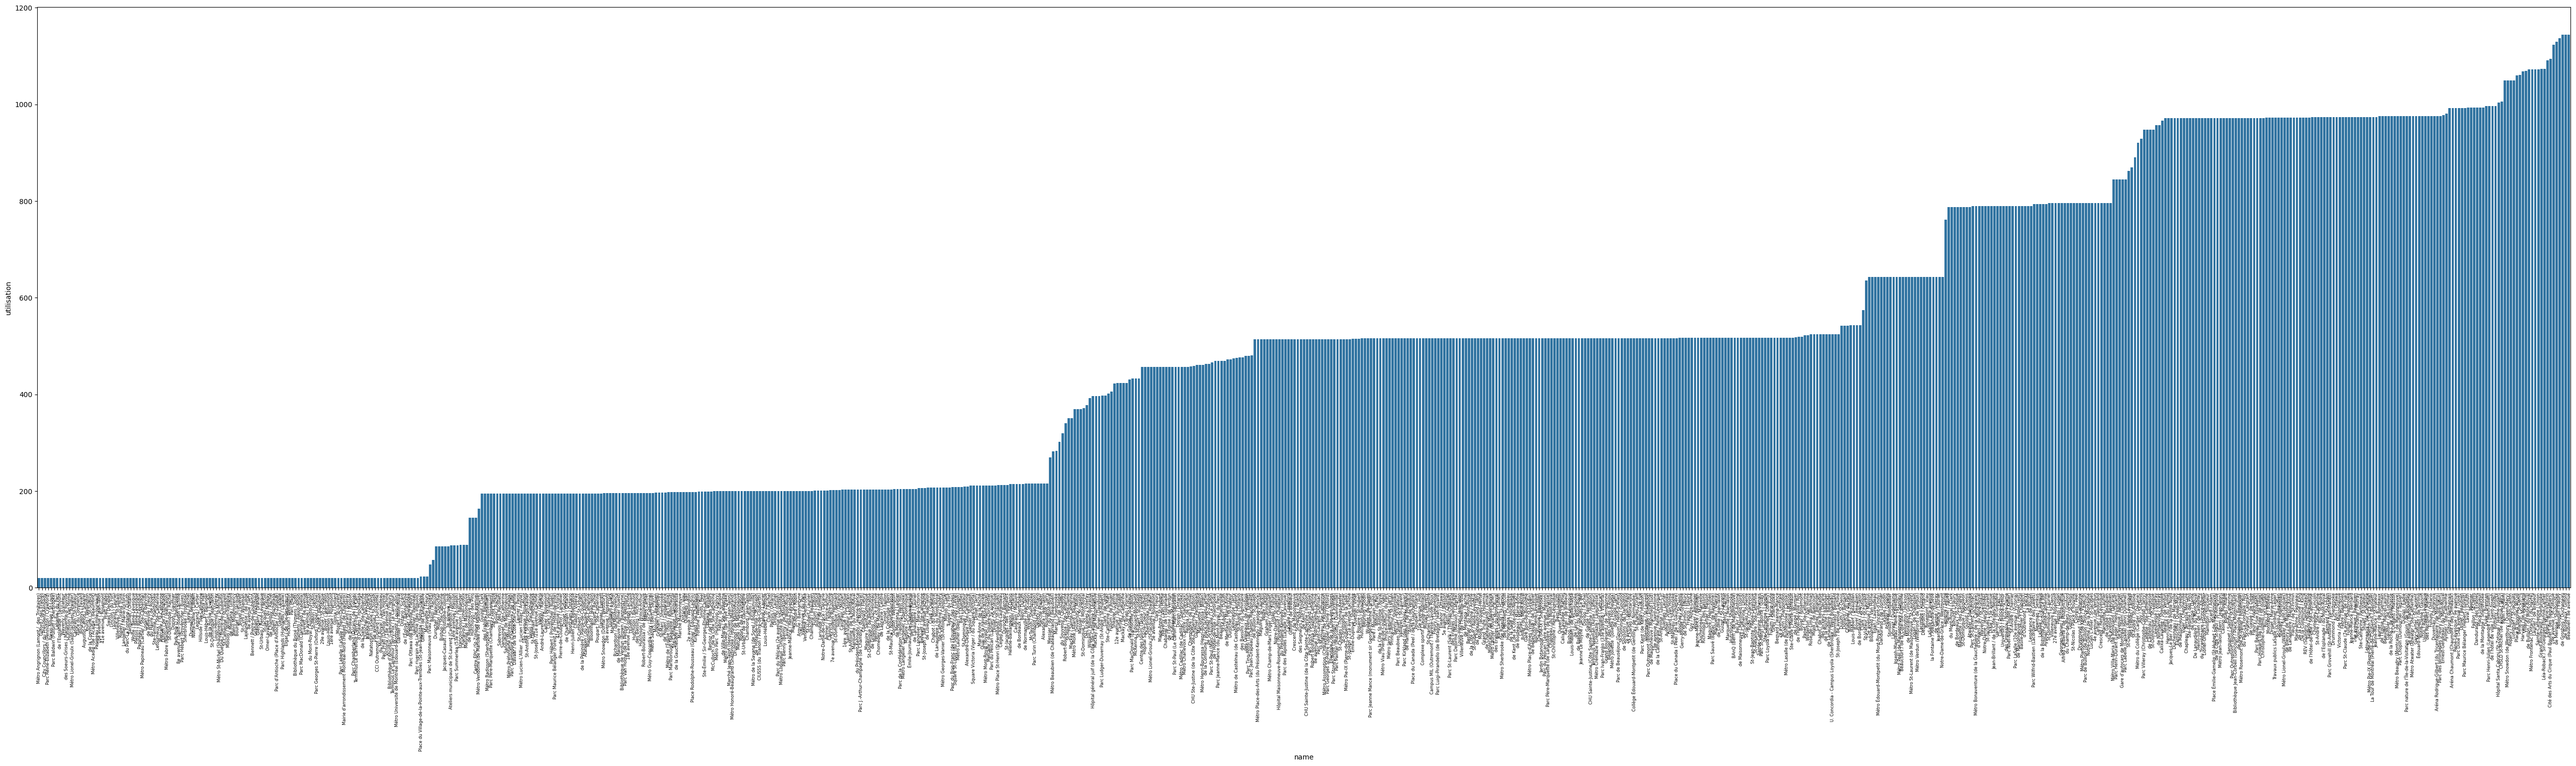

In [23]:
df_plot = df_joined.sort_values(by='utilisation' ).copy()
df_plot[df_plot['utilisation']> 2000.0]

plt.figure(figsize=(65,15))
ax = sns.barplot(data=df_plot[df_plot['utilisation']> 2000.0], y=df_plot['utilisation'], x=df_plot['name'])
l = ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontdict={'fontsize': 6})

Here the utilisation with respect to each parking stations is plotted. It is a large figure, depending of the information you are looking for you could plot a reduced amount of information for readibility. 

In [24]:
gdf = gpd.GeoDataFrame(df_joined, geometry=gpd.points_from_xy(df_stations.longitude, df_stations.latitude), crs='EPSG:4326')
#gdf = gpd.GeoDataFrame(Point(df_stations['latitude'].to_numpy(), df_stations['longitude'].to_numpy()), geometry=0, crs="EPSG:3857")

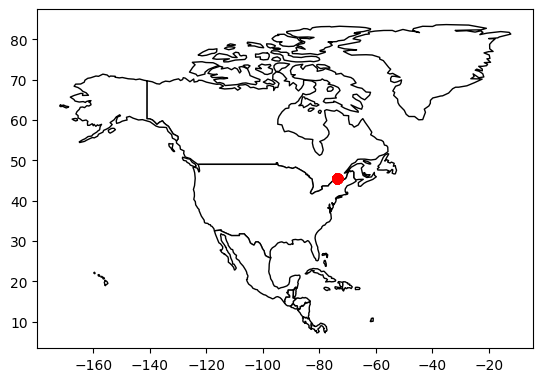

In [25]:
ax = world[world.CONTINENT == 'North America'].plot(
    color='white', edgecolor='black')

# We can now plot our ``GeoDataFrame``.
gdf.plot(ax=ax, color='red')

plt.show()

Now that we have corrected the data it is possible to plot them on a map.

In [26]:
# Create a map
m_1 = folium.Map(location=[45.513637, -73.582289], tiles='openstreetmap', zoom_start=12)

# Plots every stations on the map can be costly
#for i, row in gdf.iterrows(): 
#    Marker([row['latitude'], row['longitude']]).add_to(m_1)
# Display the map

# Plots clusters of parking stations
# Add points to the map
mc = MarkerCluster()
for idx, row in gdf.iterrows():
    mc.add_child(Marker([row['latitude'], row['longitude']]))
m_1.add_child(mc)
m_1

In [27]:
gdf.sort_values(by='count_emplacement_pk_start', ascending=False).head()

pk                                               name   latitude  \
136  256          Métro Mont-Royal (Rivard / du Mont-Royal)  45.524673   
122  242                              du Mont-Royal / Clark  45.519410   
60   173                          Marquette / du Mont-Royal  45.532290   
201  330  Parc Jeanne Mance (monument sir George-Etienne...  45.514840   
96   214                               Laurier / de Brébeuf  45.532514   

     longitude  count_emplacement_pk_start  count_emplacement_pk_end  \
136 -73.582550                     48310.0                     47720   
122 -73.586850                     36256.0                     32193   
60  -73.575440                     36052.0                     36011   
201 -73.584779                     32159.0                     23126   
96  -73.584811                     31549.0                     31211   

     utilisation                    geometry  
136          211  POINT (-73.58255 45.52467)  
122          788  POINT (-73.58685 45.51941)  
60           203  POINT (-73.57544 45.53229)  
201          516  POINT (-73.58478 45.51484)  
96          1072  POINT (-73.58481 45.53251)

<Axes: xlabel='count_emplacement_pk_start'>

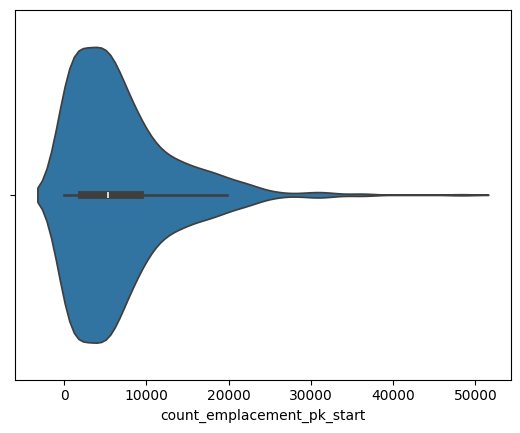

In [28]:
sns.violinplot(data=gdf, x=gdf.count_emplacement_pk_start)

In [30]:
from matplotlib import cm
# Create a base map
m_4 = folium.Map(location=[45.513637, -73.582289], tiles='cartodbpositron', zoom_start=13)


def color_producer(val):
    if val >= 20000:
        return 'darkred'
    elif val > 10000:
        return 'orange'
    elif val <= 1000:
        return 'green'

# Add a bubble map to the base map
for i in range(len(gdf['count_emplacement_pk_start'])):
    Circle(
        location=[gdf.iloc[i]['latitude'], 
                  gdf.iloc[i]['longitude']],
        radius=30,
        color=color_producer(gdf.iloc[i]['count_emplacement_pk_start'])).add_to(m_4)

# Display the map
m_4

In [31]:
# Create a base map
m_5 = folium.Map(location=[45.513637, -73.582289], tiles='cartodbpositron', zoom_start=13)


def color_producer(val):
    if val >= 20000:
        return 'darkred'
    elif val > 10000:
        return 'orange'
    elif val <= 1000:
        return 'green'

# Add a bubble map to the base map
for i in range(len(gdf['count_emplacement_pk_end'])):
    Circle(
        location=[gdf.iloc[i]['latitude'], 
                  gdf.iloc[i]['longitude']],
        radius=30,
        color=color_producer(gdf.iloc[i]['count_emplacement_pk_end'])).add_to(m_5)

# Display the map
m_5

In [32]:
from matplotlib import cm
# Create a base map
m_6 = folium.Map(location=[45.513637, -73.582289], tiles='cartodbpositron', zoom_start=13)


def color_producer(val):
    if val >= 20000:
        return 'darkred'
    elif val > 10000:
        return 'orange'
    elif val <= 1000:
        return 'green'

# Add a bubble map to the base map
for i in range(len(gdf['utilisation'])):
    Circle(
        location=[gdf.iloc[i]['latitude'], 
                  gdf.iloc[i]['longitude']],
        radius=30,
        color=color_producer(gdf.iloc[i]['utilisation'])).add_to(m_6)

# Display the map
m_6

What could be useful is to plot the destination of all the bikes taken at one particular station. 

In [33]:
df_data['start_end_pk'] = df_data['emplacement_pk_start'].astype(str) + '-' + df_data['emplacement_pk_end'].astype(str)
df_data.head()

start_date  emplacement_pk_start                 end_date  \
0  2021-06-29 17:46:28.653                    10  2021-06-29 19:33:25.700   
1  2021-04-25 18:02:39.110                    10  2021-04-25 18:13:26.139   
2  2021-08-08 18:50:31.633                    10  2021-08-08 18:58:57.585   
3  2021-10-11 17:50:15.346                    10  2021-10-11 18:25:31.726   
4  2021-09-10 15:51:58.050                    10  2021-09-10 16:21:01.403   

   emplacement_pk_end  duration_sec  is_member start_end_pk  
0                  10          6417          0        10-10  
1                 188           647          0       10-188  
2                 778           505          1       10-778  
3                 504          2116          1       10-504  
4                 780          1743          1       10-780

In [34]:
df_travels = df_data['start_end_pk'].value_counts()
df_data = df_data.join(df_travels, on='start_end_pk', lsuffix='_caller', rsuffix='_other')
df_data.head()

start_date  emplacement_pk_start                 end_date  \
0  2021-06-29 17:46:28.653                    10  2021-06-29 19:33:25.700   
1  2021-04-25 18:02:39.110                    10  2021-04-25 18:13:26.139   
2  2021-08-08 18:50:31.633                    10  2021-08-08 18:58:57.585   
3  2021-10-11 17:50:15.346                    10  2021-10-11 18:25:31.726   
4  2021-09-10 15:51:58.050                    10  2021-09-10 16:21:01.403   

   emplacement_pk_end  duration_sec  is_member start_end_pk  count  
0                  10          6417          0        10-10    763  
1                 188           647          0       10-188     39  
2                 778           505          1       10-778     39  
3                 504          2116          1       10-504    107  
4                 780          1743          1       10-780    128

In [35]:
df_start_end = df_data.groupby(['emplacement_pk_start','emplacement_pk_end']).size().reset_index().rename(columns={0:'count'}).sort_values(by='count')
df_start_end

emplacement_pk_start  emplacement_pk_end  count
211216                   638                 377      1
64216                    264                 464      1
64212                    264                 455      1
64210                    264                 452      1
202874                   614                 985      1
...                      ...                 ...    ...
276560                   949                 949   2018
151513                   469                 469   2170
152139                   470                 470   2654
116358                   381                 381   2676
253363                   860                 860   5296

[315907 rows x 3 columns]

In [36]:
def whereto(pk_start):
    '''
    
    '''
    if pk_start in df_stations['pk'].unique():
        # Create a base map
        m_6 = folium.Map(location=[45.513637, -73.582289], tiles='cartodbpositron', zoom_start=13)

        df_tojoin = df_start_end[df_start_end['emplacement_pk_start']==pk_start].rename(columns={'emplacement_pk_end': 'pk'})
        df_where_to = df_tojoin.merge(df_joined, on=['pk', 'pk'], how='left').sort_values(by='count',ascending=False)
        quantile = [df_where_to['count'].quantile(q=0.2), df_where_to['count'].quantile(q=0.9)]
        print(quantile)
        
        def color_producer_interne(val, quantile_8=quantile):
            if val >= quantile[1]:
                return 'darkred'
            elif val <= quantile[0]:
                return 'darkgreen'
            else:
                return 'orange'


        # Add a bubble map to the base map
        for i in range(len(df_where_to['count'])):
            Circle(
                location=[df_where_to.iloc[i]['latitude'], 
                        df_where_to.iloc[i]['longitude']],
                radius=30,
                color=color_producer_interne(df_where_to.iloc[i]['count'])).add_to(m_6)

        start_station = df_stations[df_stations['pk']==pk_start]
        Marker(location=[start_station['latitude'], start_station['longitude']],
               icon=folium.Icon(color='green', icon='circle-arrow-up')).add_to(m_6)
        m_6

    else:
        print('Wrong parking index')
    return m_6

def fromwhere(pk_end):
    '''
    
    '''
    if pk_end in df_stations['pk'].unique():
        # Create a base map
        m_7 = folium.Map(location=[45.513637, -73.582289], tiles='cartodbpositron', zoom_start=13)

        df_tojoin = df_start_end[df_start_end['emplacement_pk_end']==pk_end].rename(columns={'emplacement_pk_start': 'pk'})
        df_from_where = df_tojoin.merge(df_joined, on=['pk', 'pk'], how='left').sort_values(by='count',ascending=False)
        quantile = [df_from_where['count'].quantile(q=0.2), df_from_where['count'].quantile(q=0.9)]
        print(quantile)
        
        def color_producer_interne(val, quantile_8=quantile):
            if val >= quantile[1]:
                return 'darkred'
            elif val <= quantile[0]:
                return 'green'
            else:
                return 'orange'


        # Add a bubble map to the base map
        for i in range(len(df_from_where['count'])):
            Circle(
                location=[df_from_where.iloc[i]['latitude'], 
                        df_from_where.iloc[i]['longitude']],
                radius=30,
                color=color_producer_interne(df_from_where.iloc[i]['count'])).add_to(m_7)

        end_station = df_stations[df_stations['pk']==pk_end]
        Marker(location=[end_station['latitude'], end_station['longitude']],
               icon=folium.Icon(color='red', icon='circle-arrow-down')).add_to(m_7)
        m_7

    else:
        print('Wrong parking index')
    return m_7


It could be useful to see for all the bikes taken at a particular station where they are parked at the end of the trip. In this way you can have a glimpse of the distance traveled depending on the station geolocalization.

In [37]:
whereto(860)

[2.0, 32.900000000000034]


/Users/besombes/env/ds_py39/lib/python3.9/site-packages/folium/utilities.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
/Users/besombes/env/ds_py39/lib/python3.9/site-packages/folium/utilities.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
/Users/besombes/env/ds_py39/lib/python3.9/site-packages/folium/utilities.py:102: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(x) for x in coords]


In [38]:
fromwhere(276)

[2.0, 57.30000000000007]


/Users/besombes/env/ds_py39/lib/python3.9/site-packages/folium/utilities.py:94: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  float(coord)
/Users/besombes/env/ds_py39/lib/python3.9/site-packages/folium/utilities.py:100: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  if math.isnan(float(coord)):
/Users/besombes/env/ds_py39/lib/python3.9/site-packages/folium/utilities.py:102: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  return [float(x) for x in coords]


One of the conclusion is that an important number of bikes taken at a given station are returned to the same stations. Which was not intuitive for me at first.